In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model

from src.yolo3.model import *
from src.yolo3.detect import *

from src.utils.image import *
from src.utils.datagen import *
from src.utils.fixes import *

fix_tf_gpu()

In [2]:
from deepface import DeepFace

## **YOLO Model**

In [3]:
# shape (height, width) of the imput image
input_shape = (416, 416)

# class names
class_names  = ['W']

# anchor boxes
anchor_boxes = np.array(
    [
    np.array([[ 73, 158], [128, 209], [224, 246]]) /32, # output-1 anchor boxes
    np.array([[ 32,  50], [ 40, 104], [ 76,  73]]) /16, # output-2 anchor boxes
    np.array([[ 6,   11], [ 11,  23], [ 19,  36]]) /8   # output-3 anchor boxes
    ],
    dtype='float64'
)

# number of classes and number of anchors
num_classes = len(class_names)
num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

# input and output
input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

# build the model
model = yolo_body(input_tensor, num_out_filters)

# load weights
weight_path = f'pictor-ppe-v302-a3-yolo-v3-weights.h5'
model.load_weights( weight_path )

## **Classifier Model**

In [4]:
# class names
clsfr_class_names  = ['WITHOUT','WH','WV','WHV']

# input size of the classifier
clsfr_input_shape = (150, 150) # (224,224) for resnet, (299,299) fr xception

clsfr_mdl = load_model('pictor-ppe-v302-a3-vgg16-weights.h5')

In [5]:
def get_detection(img):
    # save a copy of the img
    act_img = img.copy()

    # shape of the image
    ih, iw = act_img.shape[:2]

    # preprocess the image
    img = letterbox_image(img, input_shape)
    img = np.expand_dims(img, 0)
    image_data = np.array(img) / 255.

    # raw prediction from yolo model
    prediction = model.predict(image_data)

    # process the raw prediction to get the bounding boxes
    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape = (ih, iw),
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45,
        classes_can_overlap=False)

    # convert tensor to numpy
    boxes = boxes[0].numpy()

    # new boxes
    new_boxes = []

    for box in boxes:
        # get the top-left and bottom-right corner of the box
        x1, y1, x2, y2 = box[:4].astype(int)

        # crop the image
        cropped_img = act_img[ y1:y2, x1:x2, : ]

        # resize the image
        cropped_img = letterbox_image(cropped_img, clsfr_input_shape)
        
        # preprocess
        cropped_img = np.expand_dims( cropped_img/255., 0)

        # get prediction
        y_pred = clsfr_mdl.predict(cropped_img)

        # get the predicted class
        class_pred = np.argmax(y_pred[0])

        # store the predicted class in the box
        box[-1] = class_pred

        # store the prediction probability in the box
        box[-2] *= y_pred[0][class_pred]

        # store the new box with updated class and prob
        new_boxes.append(box)

    # convert to numpy
    new_boxes = np.array(new_boxes)

    # draw the detection on the actual image
    return (act_img, new_boxes, clsfr_class_names)

## **Example**

In [6]:
def plt_imshow(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

1/1 [==============================] - 0s 180ms/step
[125.02216    29.516678  338.9616    409.22943     0.9996379   3.       ]


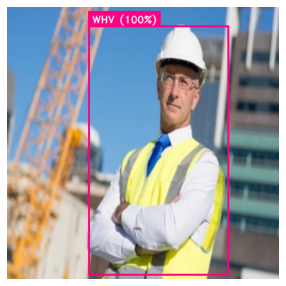

In [25]:
for i in range(1):
    # read the image
    img = cv2.imread( f'00392_jpg.rf.f05585d7cce6e6a7dfb0638cc0dcd578.jpg' )
    img = cv2.resize(img,(500,500))
    # resize
    img = letterbox_image(img, input_shape)

    # get the detection on the image
    img,box,c = get_detection(img)
    boxes=box[0]
    print(boxes)
    
    images=draw_detection(img,box,c)
    # show the image
    plt_imshow(images[:, :, ::-1])

In [23]:
import glob
for i in range(1):
    # read the image
    files=glob.glob('New folder\*.jpg')
    k=1
    for i in files:
        
        img=cv2.imread('New folder\43f4c5aeacbf3945db353d81c1a8da58.jpg')
        img=cv2.resize(img,(500,500))
#         img=cv2.imread(f'{i}')


        # resize
        img = letterbox_image(img, input_shape)

        # get the detection on the image
        print(img)
        img = get_detection(img)
#         cv2.imwrite(f'C:\Users\Administrator\Downloads\Models-20220903T104849Z-001\img_{k}.png',img)
        k+=1

        # show the image
#         plt_imshow(img[:, :, ::-1])

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [31]:
import cvzone
import cv2
import numpy as np
video1=cv2.VideoCapture('final_movie.mp4')
count=0
# fps=0
size = (250, 250)
result = cv2.VideoWriter('filename.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
while(video1.isOpened()):
#     var=False
#     var1=False
    ret,frame2 = video1.read()
#     if (count==3):
    img = cv2.resize(frame2,(500,500))
    img = letterbox_image(img, (250,250))

            # get the detection on the image
    img,box,c = get_detection(img)

    images=draw_detection(img,box,c)
    result.write(images)
        # show the image
#     elif (count==2):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)

#         images=draw_detection(img,box,c)
#         result.write(images)
#         # show the image
#     elif (count==5):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)

#         images=draw_detection(img,box,c)
#         result.write(images)
#         # show the image
#     elif (count==6):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)

#         images=draw_detection(img,box,c)
#         result.write(images)
#         # show the image
#     elif (count==7):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)
#         images=draw_detection(img,box,c)
#         result.write(images)
#         # show the image
#     elif (count==8):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)
#         images=draw_detection(img,box,c)
#         result.write(images)
# #         images=draw_detection(img,box,c)
#         # show the image
#     elif (count==9):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)
#         images=draw_detection(img,box,c)
#         result.write(images)
# #         images=draw_detection(img,box,c)
#         # show the image
#     elif (count==10):
#         img = cv2.resize(frame2,(500,500))
#         img = letterbox_image(img, (250,250))

#         # get the detection on the image
#         img,box,c = get_detection(img)
#         images=draw_detection(img,box,c)
#         result.write(images)
# #         images=draw_detection(img,box,c)
#         # show the image
    count=count+1
    cv2.imshow('hello',images)
    if cv2.waitKey(60) & 0xFF == ord('y'):
              break

video1.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 180ms/step
